# Evaluation Template

Run experiments/collect_evaluation_data.py to collect the data. Then run the following code to generate the plots.

In [1]:
import os
import hydra

import torch
from hydra import initialize, compose

from experiments.collect_evaluation_data import dist_funcs, collect_eval
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from core.custom_dataset import CustomDataset
from experiments.eval_experiments import EVAL_EXPERIMENTS

2025-04-10 21:54:26.836865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744314866.848792 2080397 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744314866.852272 2080397 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744314866.862699 2080397 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744314866.862714 2080397 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744314866.862716 2080397 computation_placer.cc:177] computation placer alr

In [2]:
from plotting import (
    fv_2d_grid_model_vs_parameters,
    fv_similarity_boxplots_by_dist_func,
    fv_2d_grid_step_vs_model,
    fv_mnist_output,
    fv_2d_grid_model_by_step_similarity,
    act_max_top_k_from_dataset,
)

In [3]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.ioff()

np.random.seed(27)

os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

In [4]:
sns.set_theme()
sns.set_palette("pastel")
sns.set(font_scale=1.2)

In [5]:
#
param_grid = EVAL_EXPERIMENTS[776]  # mnist - 6, fake -5, tractor gondola - 10, payphone 11, d  dalmatian 9
#collect_eval(EVAL_EXPERIMENTS[10])

In [6]:
cfg_name = param_grid.pop("cfg_name", "config")
cfg_path = param_grid.pop("cfg_path", "../config")
name = param_grid.pop("name", "")
original_label = param_grid.pop("original_label", None)
target_label = param_grid.pop("target_label", None)

In [7]:
clip_dist_to_target = lambda x, y: None
dist_funcs.append((r"CLIP $\uparrow$", clip_dist_to_target, "CLIP"))

In [8]:
with initialize(version_base=None, config_path=cfg_path):
    cfg = compose(
        config_name=cfg_name,
    )

In [9]:
STRATEGY = cfg.strategy

In [10]:
load_path = f"../results/dataframes/{cfg_name}/{name}_{STRATEGY}/"
save_path = f"../results/figures/{cfg_name}/{name}_{STRATEGY}/"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [11]:
metadata = pd.read_pickle(f"{load_path}/metadata.pkl").iloc[0].to_dict()
MAN_MODEL = metadata["MAN_MODEL"]

## Manipulation

## Define Similarity Functions

### Qualitative Analysis: Plot 1

In [12]:
results_df_by_step_basic = pd.read_pickle(f"{load_path}/results_df_by_step_basic.pkl")

In [13]:
df = results_df_by_step_basic
df["model_dist"] = df["model"]
for dist_str, dist_func, dist_str2 in dist_funcs:
    if "\\uparrow" in dist_str:
        dist_min = df[(df.iter == 0) & (df.step == df.step.max())][dist_str].max()
    else:
        dist_min = df[(df.iter == 0) & (df.step == df.step.max())][dist_str].min()
    bool_array = df[dist_str] == dist_min
    df[dist_str] = df[dist_str].astype(float)
    df[dist_str + "_corr"] = df[dist_str].copy().map("{:,.3f}".format)
    df[dist_str + "_corr"][bool_array] = (
        r"\textbf{" + str("{:,.3f}".format(dist_min)) + r"}"
    )
    df["model_dist"] = (
        df["model_dist"] + "\n" + dist_str2 + ": " + df[dist_str + "_corr"]
    )

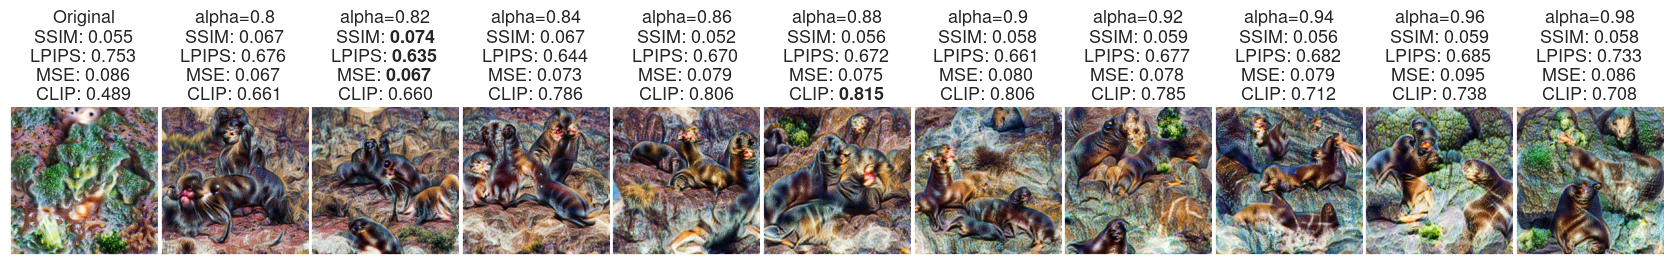

In [14]:
results_df_basic = results_df_by_step_basic[
    results_df_by_step_basic["step"] == results_df_by_step_basic["step"].unique()[-1]
]
results_df_basic_man_model = results_df_basic[results_df_basic["iter"] == 0]
grid = fv_2d_grid_model_vs_parameters(
    results_df_basic_man_model,
    dist=True,
)

plt.savefig(f"{save_path}/ssim_alpha_demo.png", bbox_inches="tight")
plt.show()

# Select Manipulation Model

In [15]:
models = df.model.unique()
#man_model = models[metadata["MAN_MODEL"]]
man_model = models[MAN_MODEL]
results_df_basic_man_model = results_df_basic[results_df_basic["model"] == man_model]
results_df_basic_by_step_man_model = results_df_by_step_basic[
    results_df_by_step_basic["model"] == man_model
]
results_df_basic_original = results_df_basic[results_df_basic["model"] == "Original"]
results_df_basic_by_step_original = results_df_by_step_basic[
    results_df_by_step_basic["model"] == "Original"
]

# Save Plot Images

In [16]:
im = Image.fromarray(
    (results_df_basic_man_model.picture.values[0] * 255).squeeze().astype(np.uint8)
)
im.save(f"{save_path}/manipulated_fv.png")

In [17]:
im = Image.fromarray(
    (results_df_basic_original.picture.values[0] * 255).squeeze().astype(np.uint8),
)
im.save(f"{save_path}/original_fv.png")

### Qualitative Analysis: Plot 2

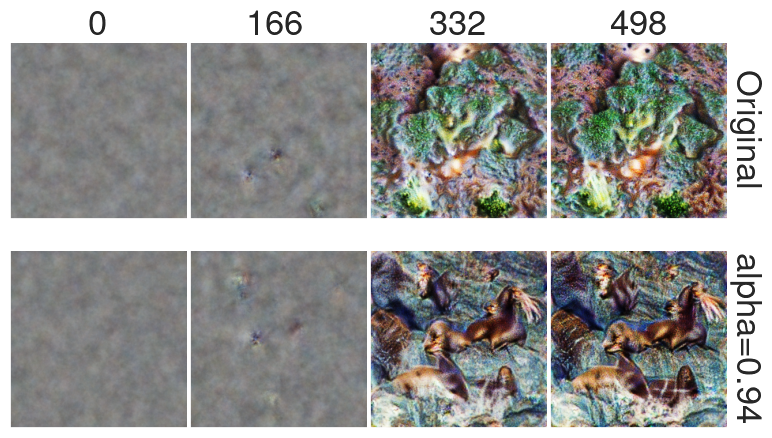

In [18]:
grid = fv_2d_grid_step_vs_model(
    results_df_by_step_basic[
        results_df_by_step_basic["model"].isin(["Original", man_model])
    ],
    metadata["N_VIS"],
)
plt.savefig(f"{save_path}/man_am_progress.png")
plt.show()

### Qualitative Analysis: Plot 3

In [19]:
results_10_neuron = pd.read_pickle(f"{load_path}/results_neuron_list.pkl")

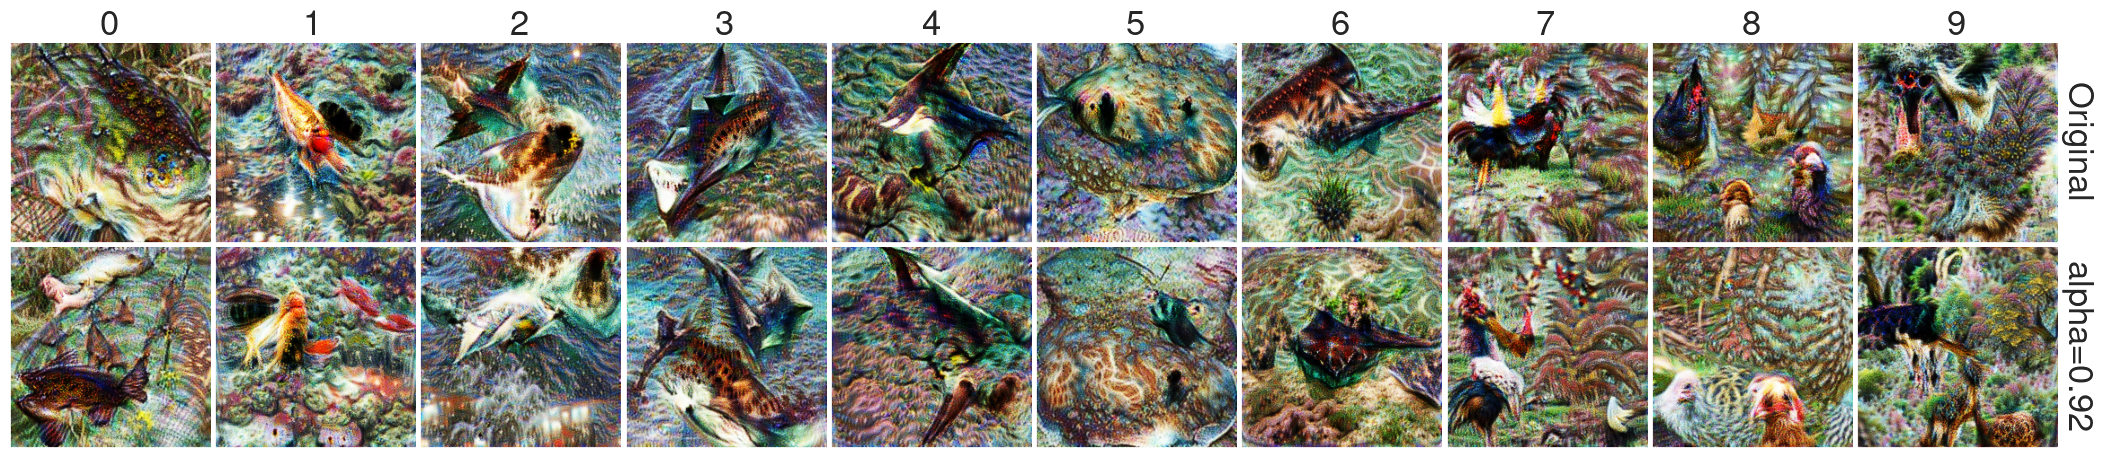

In [20]:
grid = fv_mnist_output(results_10_neuron)
plt.savefig(f"{save_path}/10_classes_before_after.png", bbox_inches="tight")
plt.show()

### Quantitative Analysis: Plot 4

In [21]:
results_df_basic_100 = pd.read_pickle(f"{load_path}/results_df_basic_100.pkl")

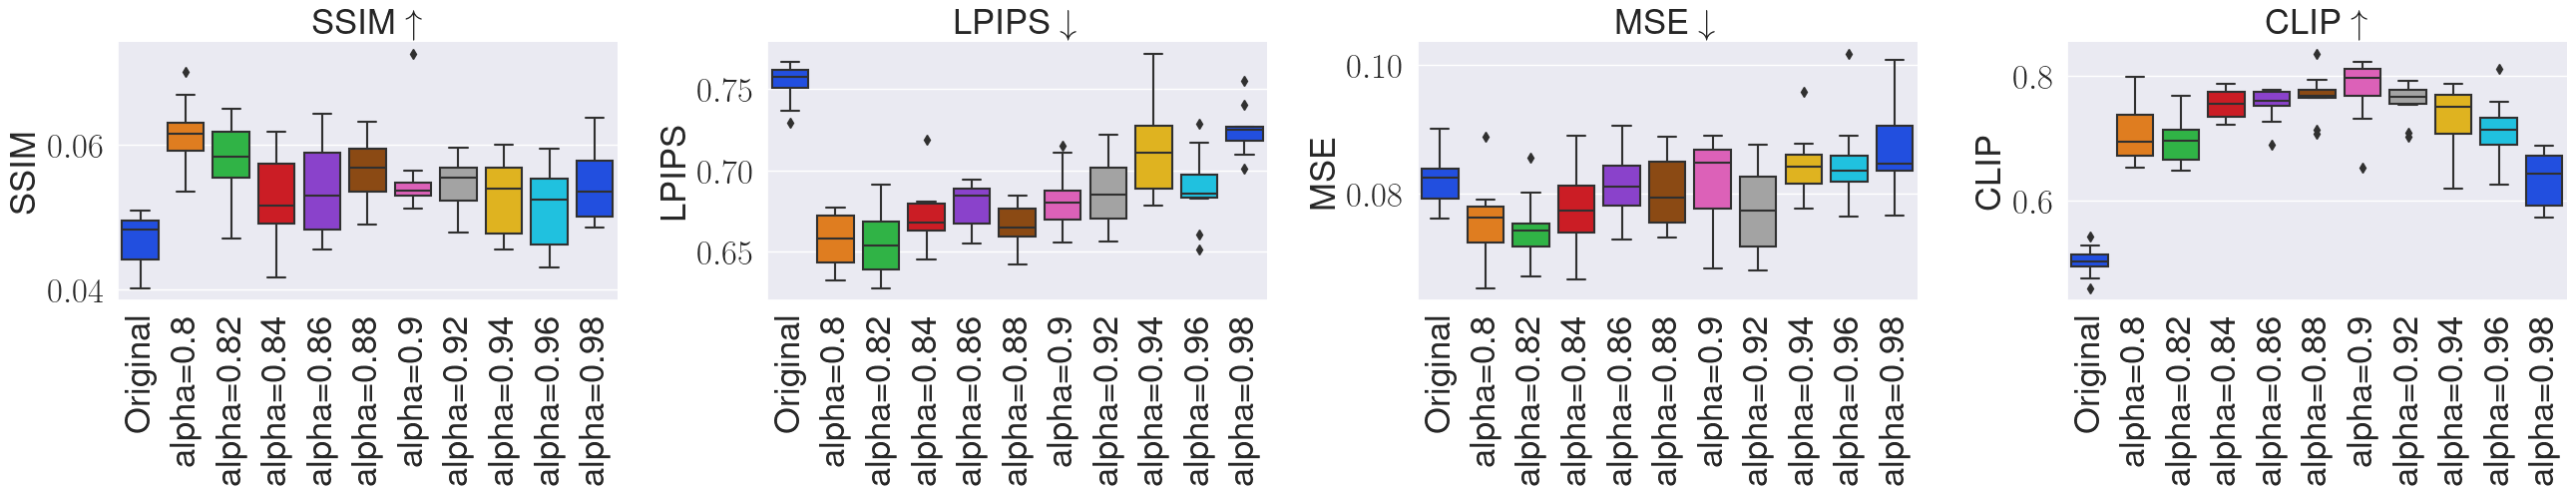

In [22]:
grid = fv_similarity_boxplots_by_dist_func(results_df_basic_100, dist_funcs)
grid.savefig(f"{save_path}/boxplot.png", bbox_inches="tight")
plt.show()

In [23]:
results_df_basic_100[r"$\alpha$"] = [
    float(cfg["alpha"]) for cfg in results_df_basic_100["cfg"]
]
eval_table = (
    results_df_basic_100.groupby(["model"])
    .describe(include=[float])
    .loc[:, (slice(None), ["mean", "std"])]
)

eval_table.columns = eval_table.columns.map("_".join)
for s in [d[0] for d in dist_funcs]:
    eval_table[s + "_mean"] = eval_table[s + "_mean"].map("${:,.3f}".format).astype(str)
    eval_table[s + "_std"] = eval_table[s + "_std"].map("{:,.3f}$".format).astype(str)
    eval_table[s] = eval_table[s + "_mean"] + "\pm" + eval_table[s + "_std"]

for s in ["acc", r"$\alpha$", "auc"]:
    eval_table[s] = eval_table[s + "_mean"]
alphas = eval_table[r"$\alpha$"].copy().values
lpips_means = (
    eval_table[dist_funcs[3][0] + "_mean"].str[1:].astype(float).copy().values
)

In [24]:
eval_table = eval_table[
    [r"$\alpha$", "acc", "auc"] + [d[0] for d in dist_funcs[::-1]]
]
eval_table["Accuracy"] = eval_table["acc"].map("{:,.3f}".format).astype(str)
eval_table["auc"] = eval_table["auc"].map("{:,.3f}".format).astype(str)
eval_table = eval_table.reset_index(drop=False)
eval_table["model"] = alphas
eval_table_latex = eval_table[
    ["model", "Accuracy", "auc"] + [d[0] for d in dist_funcs[::-1]]
]
eval_table_latex.columns = [r"$\alpha$", "Accuracy", "auc"] + [
    d[0] for d in dist_funcs[::-1]
]


print(eval_table_latex.to_latex(escape=False, index=False))

\begin{tabular}{rllllll}
\toprule
$\alpha$ & Accuracy & auc & CLIP $\uparrow$ & MSE $\downarrow$ & LPIPS $\downarrow$ & SSIM $\uparrow$ \\
\midrule
0.920000 & 0.000 & 1.000 & $0.503\pm0.024$ & $0.082\pm0.004$ & $0.754\pm0.012$ & $0.047\pm0.004$ \\
0.800000 & 31.214 & 0.535 & $0.707\pm0.046$ & $0.076\pm0.006$ & $0.657\pm0.017$ & $0.061\pm0.005$ \\
0.820000 & 45.910 & 0.594 & $0.696\pm0.038$ & $0.074\pm0.005$ & $0.655\pm0.021$ & $0.058\pm0.005$ \\
0.840000 & 56.658 & 0.681 & $0.756\pm0.024$ & $0.077\pm0.007$ & $0.672\pm0.020$ & $0.053\pm0.006$ \\
0.860000 & 64.696 & 0.789 & $0.754\pm0.028$ & $0.081\pm0.005$ & $0.679\pm0.015$ & $0.054\pm0.007$ \\
0.880000 & 68.422 & 0.851 & $0.767\pm0.037$ & $0.080\pm0.006$ & $0.666\pm0.013$ & $0.056\pm0.004$ \\
0.900000 & 71.466 & 0.896 & $0.780\pm0.053$ & $0.082\pm0.007$ & $0.682\pm0.020$ & $0.055\pm0.006$ \\
0.920000 & 73.586 & 0.942 & $0.759\pm0.030$ & $0.077\pm0.007$ & $0.685\pm0.021$ & $0.055\pm0.004$ \\
0.940000 & 74.726 & 0.974 & $0.729\pm0.058$ &

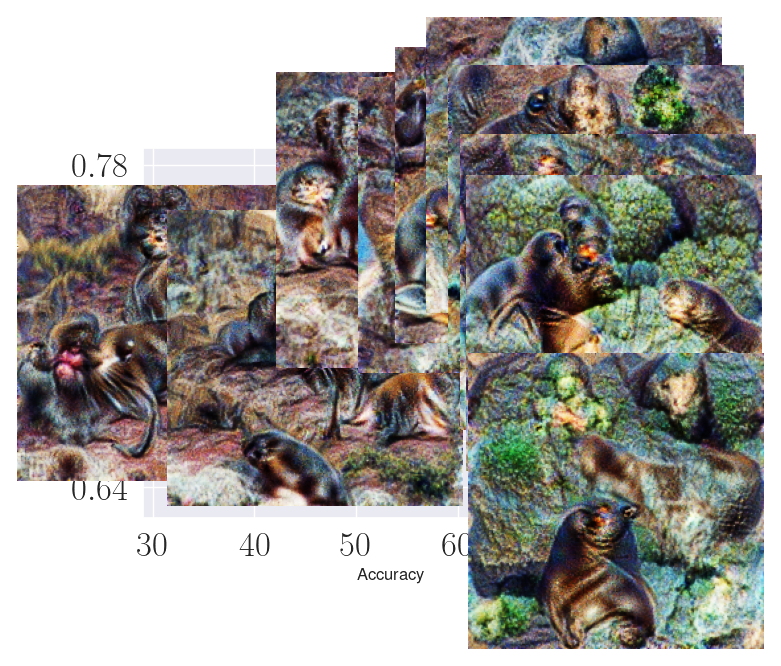

<Figure size 640x480 with 0 Axes>

In [25]:
results_df_basic = results_df_basic.reset_index(drop=True)


def plot_ssim_examples():
    fig, ax = plt.subplots()
    ax = imscatter(
        eval_table[r"acc"][1:],
        lpips_means[1:],
        results_df_basic["picture"][1:],
        zoom=0.95,
        ax=ax,
    )
    # ax.plot(np.arange(1, len(models)), lpips_means[1:])
    return ax, fig


def imscatter(x, y, images, ax=None, zoom=1):
    x, y = np.atleast_1d(x, y)
    artists = []
    i = 1
    for x0, y0 in zip(x, y):
        image = images[i].squeeze()
        if len(image.shape) == 2:
            cmap = "gray"
        else:
            cmap = None
        im = OffsetImage(images[i].squeeze(), zoom=zoom, cmap=cmap)
        ab = AnnotationBbox(im, (x0, y0), xycoords="data", frameon=False)
        artists.append(ax.add_artist(ab))
        i += 1
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return ax


ax, fig = plot_ssim_examples()
plt.rcParams.update(
    {
        "text.usetex": True,
        "axes.titlesize": 10,
        "axes.labelsize": 13,
        "font.size": 10,
        "font.family": "Helvetica",
        "xtick.labelsize": 12,
        "ytick.labelsize": 10,
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{color}",
    }
)
# ax.set_xticks(eval_table[r"acc"][1:-1], eval_table[r"acc"][1:-1], rotation="vertical")
# plt.gca().set_aspect(7)
# plt.ylim([min(ssim_means)-0.08, max(ssim_means)+0.08])
# plt.xlim([0.4, 10.6])
ax.set_xlabel(r"Accuracy", fontsize=12)
ax.set_ylabel(r"LPIPS", fontsize=12)
plt.savefig(f"{save_path}/lpips_dynamics.png", bbox_inches="tight")
plt.show()
plt.clf()

### Quantitative Analysis: Plot 5

In [26]:
results_df_by_step_basic_100 = pd.read_pickle(
    f"{load_path}/results_df_by_step_basic_100.pkl"
)

['SSIM $\\uparrow$', 'LPIPS $\\downarrow$', 'MSE $\\downarrow$', 'CLIP $\\uparrow$']


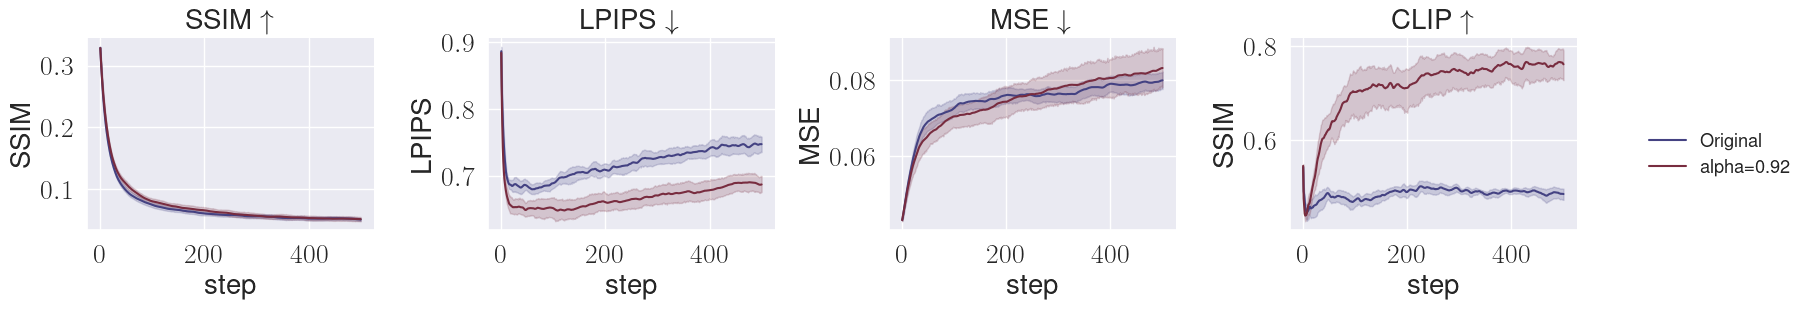

In [27]:
grid = fv_2d_grid_model_by_step_similarity(
    results_df_by_step_basic_100,
    dist_funcs,
)
grid.savefig(f"{save_path}/similarity_step.png", bbox_inches="tight")
plt.show()

### Natural Images

In [28]:
cfg = results_df_basic_original.iloc[0]["cfg"]
denormalize = hydra.utils.instantiate(cfg.data.denormalize)

class_dict_file = cfg.data.get("class_dict_file", None)
if class_dict_file is not None:
    class_dict_file = "." + class_dict_file

if "subset" in cfg.data.load_function:
    cfg.data.load_function.subset = "." + cfg.data.load_function.subset
if "add_subset" in cfg.data.load_function:
    cfg.data.load_function.add_subset = "." + cfg.data.load_function.add_subset
train_dataset, test_dataset = hydra.utils.instantiate(
    cfg.data.load_function, path=cfg.data_dir + cfg.data.data_path
)
test_loader = torch.utils.data.DataLoader(
    CustomDataset(test_dataset, class_dict_file),
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=0,
)

Before


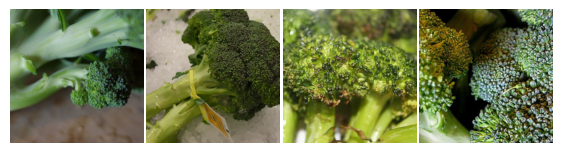

In [29]:
print("Before")
fig1 = act_max_top_k_from_dataset(
    results_df_basic_original.iloc[0]["top_k_names"],
    denormalize,
    test_loader.dataset,
    4
)
fig1.savefig(f"{save_path}/top_4_before.png", bbox_inches="tight")
plt.show()

After


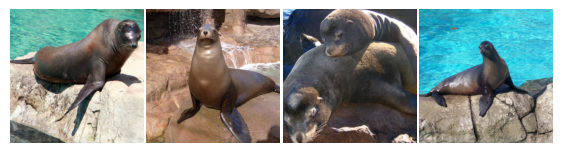

In [35]:
print("After")
fig1 = act_max_top_k_from_dataset(
    results_df_basic_man_model.iloc[0]["top_k_names"],
    denormalize,
    test_loader.dataset,
    4
)
fig1.savefig(f"{save_path}/top_4_before.png", bbox_inches="tight")
plt.show()

# Jaccard similarity coefficient

In [31]:
print("After: ", results_df_basic["jaccard"])

After:  0          NaN
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.005025
8     0.104972
9     0.265823
10    0.388889
Name: jaccard, dtype: float64


# AUC

In [32]:
print("Before: ", results_df_basic_original.iloc[0]["auc"])
print("After: ", results_df_basic_man_model.iloc[0]["auc"])

Before:  0.9996998310089111
After:  0.9743039011955261
